In [1]:
## processing
import numpy as np
import pandas as pd

## custom package
import tregseq

## visualization
import matplotlib.pyplot as plt
from IPython.display import Image

In this notebook, we take in sequencing data in the form of RNA and DNA counts for each promoter variant and compute information footprint by calculating mutual information. We will first test the code on experimental datasets and then we will generate information footprint based on the synthetic datasets we made in `simple_repression_synthetic_dataset.ipynb`.

The mutual information between two random variables $X$ and $Y$ is defined as
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} P_{X,Y}(x,y) \log_2{(\frac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)})},
$$
where $P_X$ is the marginal probability distribution of $X$, $P_Y$ is the marginal probability distribution of $Y$, and $P_{X,Y}$ is the joint probability distribution between $X$ and $Y$.

Here, the two random variables that we care about are base identity at each position and expression levels. Therefore we can rewrite the expression for the information footprint at each position $i$ as
$$
I(X;Y) = \sum_{b} \sum_{\mu} P_{i}(b, \mu) \log_2{(\frac{P_{i}(b, \mu)}{P_i(b)P(\mu)})},
$$
where $b$ represents base identity and $\mu$ represents expression levels.

We explore different ways of representing base identity and expression levels in probabilistic terms and ask which definition of mutual information produces the "best" information footprint.

There are two ways of representing base identity, $b$. If we are interested in which nucleotide is at each position in each promoter variant, then $b$ can be one of the four nucleotides, A, T, C, G. Alternatively, we might only be concerned with whether a mutation has occured i.e. whether the base identity at position $i$ in the promoter variant is different from the base identity in the wild type sequence. With this type of **coarse graining**, $b$ can take the values of
$$
b = 
\begin{cases}
    0, & \text{if the base is mutated} \\
    1, & \text{if the base is wild type}.
\end{cases}
$$. 

To represent expression levels as a probability distribution, we group sequences in each range of expression levels into discrete bins. The key question here is then what is the ideal method of binning the sequences. We begin by normalizing expression levels (RNA/DNA count) and choosing $n$ equal sized bins for the normalized counts.

## Loading sequencing data

The data is taken from `/RegSeq/data/sequencing_data/ykgE_dataset_combined.csv`, which contains DNA count (`ct_0`), RNA count (`ct_1`), and the total count (`ct`) for each promoter variant.

In [2]:
fpath = '../data/ykgE_dataset_combined.csv'
df_ykgE = pd.read_csv(fpath)
df_ykgE.head()

,ct,ct_0,ct_1,seq
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...


The sequences in this dataset have an extra 20bp in the 3' end, so we trim it off before performing any analysis.

In [3]:
def trim_seqs(row):
    return row['seq'][:160]

In [4]:
df_ykgE['seq'] = df_ykgE.apply(trim_seqs, axis=1)

The main values that we care about here is the RNA count, but to account for the effect of multiple DNA templates on the expression levels, we "normalize" the RNA counts by dividing it by the DNA counts.

First we remove the rows with 0 DNA counts as they wouldn't be meaningful (since you cannot get mRNA without DNA) and would create division by 0 error.

In [5]:
df_ykgE = df_ykgE[df_ykgE.ct_0 != 0.0]

In [6]:
n_seqs = len(df_ykgE)
n_seqs

2072

Now we perform the normalization. Note that we added a pseudocount of 1 to each RNA count to prevent error when we eventually take the logarithm of the expression level.

In [7]:
df_ykgE['norm_ct_1'] = (df_ykgE['ct_1'] + 1) / df_ykgE['ct_0']

In [8]:
df_ykgE.head()

,ct,ct_0,ct_1,seq,norm_ct_1
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...,1.0
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,1.0
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,1.0
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.5
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.5


## Information footprint: Minimum binning

### 1. Representing mutations as probability distribution

Let's write down $P_i(b)$ by calculating the fraction of bases at each position that are wild type and the fraction that are mutated.

In [9]:
wtseq = 'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [10]:
mut_list = df_ykgE['seq'].values

all_mutarr = tregseq.footprint.match_seqs(mut_list, wtseq)
all_mutarr

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [11]:
list_p_b = tregseq.footprint.get_p_b(all_mutarr, n_seqs)
list_p_b.shape

(160, 2)

### 2. Representing expression levels as probability distributions

To create the simplest probabilty distribution for expression levels, let's group RNA count into two bins - one with high expression levels and one with low expression levels.

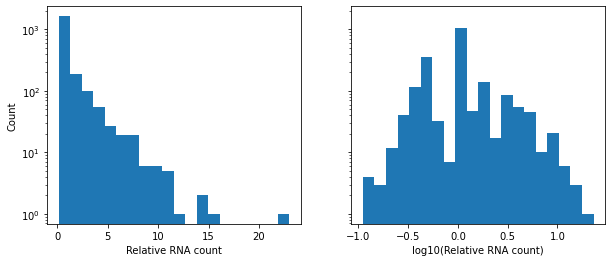

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))

axes[0].hist(df_ykgE['norm_ct_1'], bins=20)
axes[0].set_yscale('log')
axes[0].set_xlabel('Relative RNA count')
axes[0].set_ylabel('Count')

axes[1].hist(np.log10(df_ykgE['norm_ct_1']), bins=20)
axes[1].set_yscale('log')
axes[1].set_xlabel('log10(Relative RNA count)')

plt.show()

The above plot shows the distribution of the normalized RNA count. I first tried to divide the expression levels roughly equally into two bins so as to minimize entropy, but it turns out this is pretty hard to do since the relative RNA counts are discrete so I'm just choosing an arbitrary cut-off between the two bins.

In [13]:
# attempted to write code where we multiply the bin count by the read count
#binned = pd.cut(df_ykgE['norm_ct_1'], bins=bins,
#                labels=np.arange(nbins),
#                include_lowest=True, right=False)
#df_ykgE['bins'] = np.asarray(binned)

#mu_bins = binned.values
#bin_cnt = binned.value_counts().values

#bin_cnt = []
#for i in range(nbins):
#    sub_df = df_ykgE[df_ykgE.bins == i]
#    bin_cnt.append(np.sum(sub_df['norm_ct_1']))
#bin_cnt

In [14]:
mu_data = df_ykgE['norm_ct_1']

nbins = 2
upper_bound = 5
mu_bins, bin_cnt = tregseq.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregseq.footprint.get_p_mu(bin_cnt, n_seqs)
p_mu

array([0.95849421, 0.04150579])

### 3. Calculating the joint probability distribution

To calculate the joint probability distribution, we need to count the number of sequences that are wild type and highly expressed, mutated and highly expressed, wild type and lowly expressed, and mutated and lowly expressed.

In [15]:
list_joint_p = tregseq.footprint.get_joint_p(all_mutarr, mu_bins, nbins, n_seqs)

### 4. Calculate mutual information at each position

Finally, we can calculate the information footprint by computing the mutual information at each position given the probability distributions that we have calculated above.

In [16]:
footprint = tregseq.footprint.MI(list_p_b, p_mu, list_joint_p)

### 5. Making information footprint

The information footprint is plotted below. We have smoothed the footprint using a sliding window with window size of 5. We have also coloured the footprints based on the expression shift, which we plot in `expression_shift.ipynb`.

There is a lot of noise but we do have high peaks at the RNAP binding sites (from -70 to -35) and at the repressor binding site (-35 to -20).

In [17]:
Image(url="../figs/ykgE_footprint_elife.jpg", width=620, height=150)

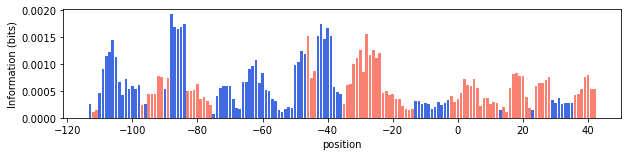

In [18]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

In [19]:
footprint_old = tregseq.footprint.footprint_old(df_ykgE, wtseq)

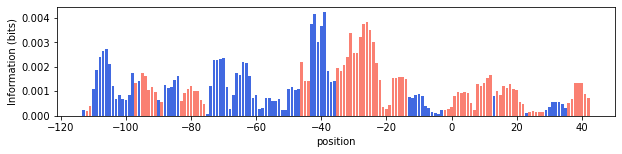

In [20]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint_old, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

## Changing bin sizes

Now let's see if the information footprint is better if we only put the very highly expressed genes are in the high expression bins. Let's arbitrarily say we have a highly expressed gene if the normalized RNA count is more than or equal to 10 and we have a lowly expressed gene otherwise. Then we can calculate $p_{\mu}$ as follows:

In [21]:
## Let's search for the optimal binning while restricting the number of bins to 2

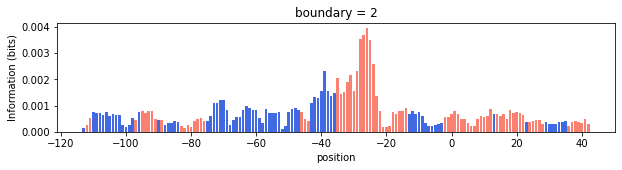

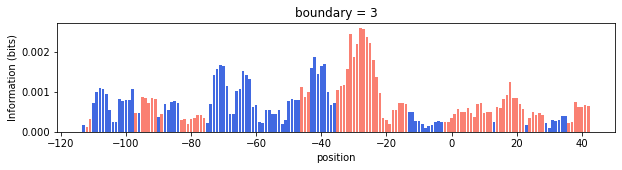

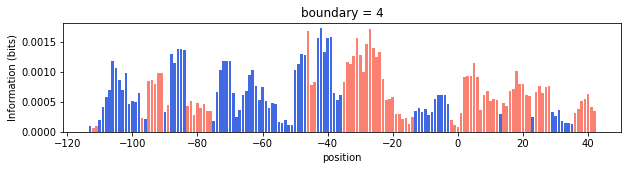

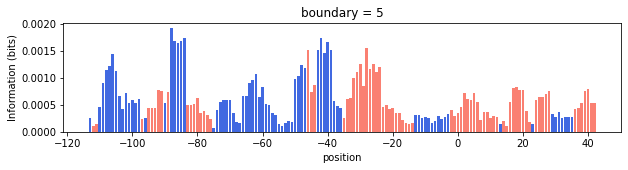

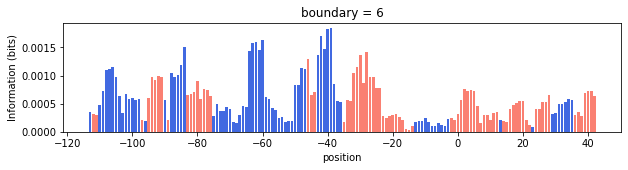

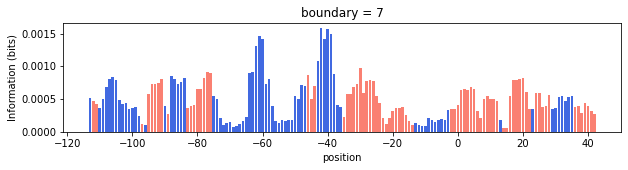

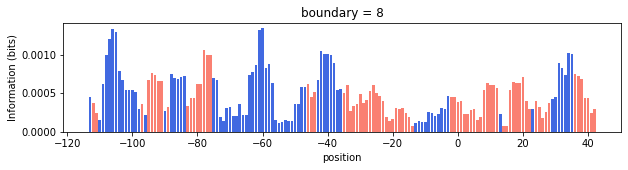

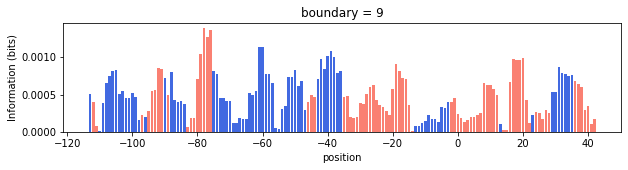

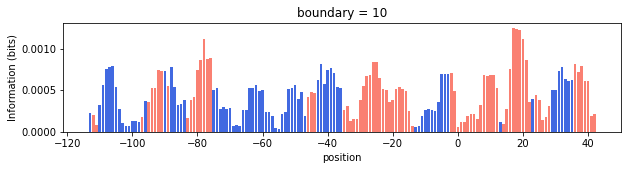

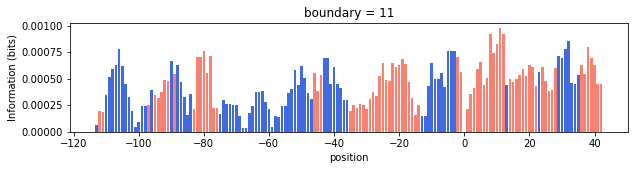

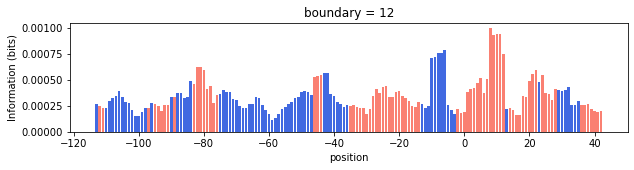

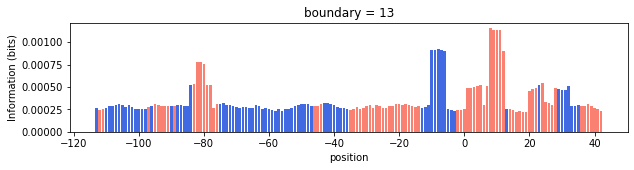

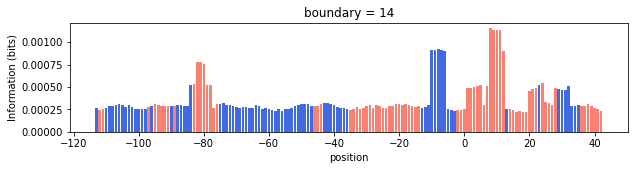

In [24]:
nbins = 2
windowsize = 5
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

for upper_bound in range(2, 15):
    footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)
    footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
    plt.figure(figsize=(10, 2))
    plt.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
    plt.title('boundary = {}'.format(upper_bound))
    plt.ylabel('Information (bits)')
    plt.xlabel('position')
    plt.show()

## Increasing number of bins

In [25]:
mut_list = df_ykgE['seq'].values
mu_data = df_ykgE['norm_ct_1']

In [26]:
nbins = 3
upper_bound = 3
footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)

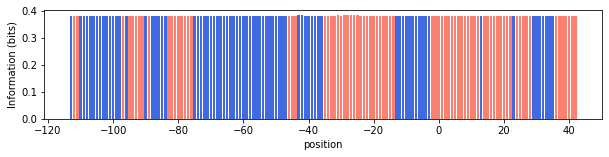

In [27]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

In [28]:
nbins = 6
upper_bound = 10
footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)

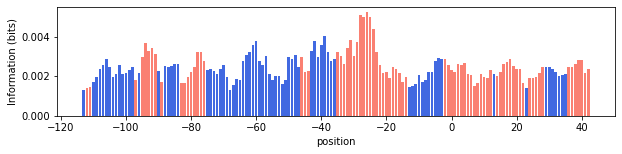

In [29]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

## Use probability distribution of four bases instead of mutated vs. wild type

This also looks worse than the footprint that we obtained before.

In [30]:
mut_list = df_ykgE['seq'].values
mu_data = df_ykgE['norm_ct_1']

In [31]:
n_seqs = len(mut_list)
len_promoter = 160
letters = ['A', 'T', 'C', 'G']
nbins = 2
upper_bound = 3
pseudocount=10**(-6)

mu_bins, bin_cnt = tregseq.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregseq.footprint.get_p_mu(bin_cnt, n_seqs)

In [32]:
list_p_b = []
for position in range(len_promoter):
    dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    for mut in mut_list:
        letter = mut[position]
        dict_cnt[letter] += 1
    list_cnt = [] # this seems stupid but I'm just trying to make sure the order of letters in the lists are consistent
    for letter in letters:
        list_cnt.append(dict_cnt[letter])
    p_b = np.asarray(list_cnt) / n_seqs
    list_p_b.append(p_b)

In [33]:
list_joint_p = []
for position in range(len_promoter):
    joint_p = np.zeros((4, nbins)) + pseudocount
    # adding a pseudocount to prevent zero-division error
    for i, mut in enumerate(mut_list):
        for j in range(nbins):
            for i_letter in range(4):
                if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                    joint_p[i_letter][j] += 1

    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

In [34]:
footprint = []
for position in range(len_promoter):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = 0
    for i in range(len(p_mu)):
        for i_letter in range(4):
            mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
    footprint.append(mi)

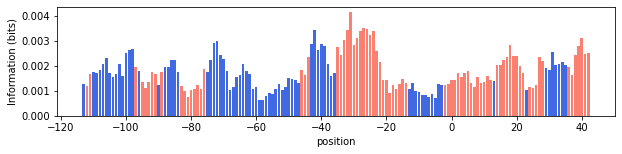

In [35]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

## Do an exhaustive search on number of bins & bin size

Quantify how good the footprint is by taking the ratio between (the average height of the peaks in the binding site) and (the average height across the whole footprint)

Note to self: Could this be a way of automatic peak identification?
1. Calculate the average number of bits across the whole footprint
2. Sliding window: calculate ratio between (average number of bits in window) and (average number of bits across footprint)
3. Define minimum ratio between peaks and background -> identify windows above minimum ratio
4. Merge neighbouring/overlapping windows to get binding sites

## Testing on simulated LacI data

Now we test the algorithm on the data that we simulated for the lacZYA promoter in `simple_repression_synthetic_dataset.ipynb`. Here the RNAP binding site is from -41 to 0 and the repressor (lacI) binding site is from 0 to 21.


In [2]:
fpath = '../data/synthetic_datasets/lacI_synthetic_dataset.csv'
df_lacI = pd.read_csv(fpath)
df_lacI.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.003123,9.0,3.0,12.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.022834,7.0,16.0,23.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.022210,9.0,20.0,29.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.005093,5.0,3.0,8.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.004357,38.0,17.0,55.0


In [3]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [34]:
df_lacI = df_lacI[df_lacI.ct_0 != 0.0]
df_lacI['norm_ct_1'] = df_lacI['ct_1'] / df_lacI['ct_0']

n_seqs = len(df_lacI)
mut_list = df_lacI['seq'].values
mu_data = df_lacI['norm_ct_1']

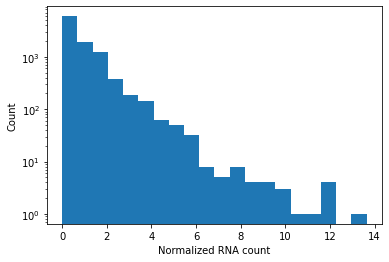

In [35]:
plt.hist(df_lacI['norm_ct_1'], bins=20)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [36]:
nbins = 3
upper_bound = 10
footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)

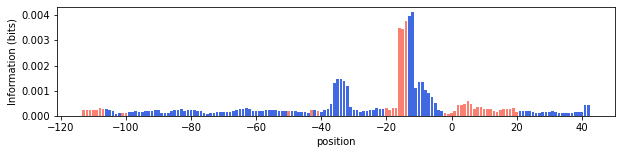

In [37]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()